In [1]:
import sys
sys.path.append("models/raster")
sys.path.append("models/vector")
sys.path.append("models/multimodal")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from auxiliary.visualization import visualize_confusion_matrix
from auxiliary.misc import get_model_name

from features import important_features

from initialize_multimodal import load_trained_multimodal_model
from dataset_multimodal import BuildingMultimodalDataset
from metrics_multimodal import get_metrics_multimodal
from predict_multimodal import get_activations_multimodal
from thresholds_multimodal import multimodal_thresholds

from models.pr_roc import get_pr_roc, plot_pr_curve, plot_roc_curve
from models.operators import elimination_operators, selection_operators, threshold_dic_to_tensor

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
    vector_path = "../scratch/vector"
    multimodal_path = "../scratch/multimodal"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"
    vector_path = "../data.nosync/vector"
    multimodal_path = "../data.nosync/multimodal"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

In [5]:
def load_validation_test_multimodal_dataset(operator_model, operators_to_predict, features, attach_roads, subset):
    '''Loads the validation and test dataset for the given model.'''
    # define path to validation and test data
    path_to_raster_validation_data = os.path.join(raster_path, "training_data", operator_model, "validation")
    path_to_vector_validation_data = os.path.join(vector_path, "training_data", operator_model, "validation")
    path_to_raster_test_data = os.path.join(raster_path, "training_data", operator_model, "test")
    path_to_vector_test_data = os.path.join(vector_path, "training_data", operator_model, "test")

    # construct validation Dataset (no shuffling)
    validation_set = BuildingMultimodalDataset(path_to_raster_validation_data, 
                                               path_to_vector_validation_data, 
                                               operators=operators_to_predict,
                                               features=features,
                                               attach_roads=attach_roads,
                                               raster_transform=None,
                                               vector_transform=None,
                                               subset=subset)
    
    # construct test Dataset (no shuffling)
    test_set = BuildingMultimodalDataset(path_to_raster_test_data, 
                                         path_to_vector_test_data, 
                                         operators=operators_to_predict,
                                         features=features,
                                         attach_roads=attach_roads,
                                         raster_transform=None,
                                         vector_transform=None,
                                         subset=subset)

    return validation_set, test_set

In [6]:
def compute_multimodal_evaluation_metrics(model_filename):
    '''Given the filename of a multimodal model, computes, saves and prints the accuracy metrics.'''
    operator_model_map = {"eli": "elimination", "sel": "selection"}
    
    # extract necessary information from model filename
    model_filename_split = model_filename.split("_")
    architecture = model_filename_split[0]
    architecture_vector = architecture.split("+")[1]
    operator_model = operator_model_map[model_filename_split[1]]
    operators_to_predict = elimination_operators if operator_model == "elimination" else selection_operators
    attach_roads = True if model_filename_split[2] == "attachRoadsTrue" else False
    n_training_samples = int(model_filename_split[-4][:-1])
    n_epochs = int(model_filename_split[-3][:-2])
    batch_size = int(model_filename_split[-2][2:])
    device_trained_on = model_filename_split[-1][:-4]

    # load the trained model
    model = load_trained_multimodal_model(model_filename, multimodal_path, raster_path, vector_path, device)
    print(model)

    # define important features
    features = important_features[f"{architecture_vector} {operator_model}"]

    # load test set
    _, test_set = load_validation_test_multimodal_dataset(operator_model=operator_model, 
                                                          operators_to_predict=operators_to_predict, 
                                                          features=features,
                                                          attach_roads=attach_roads, 
                                                          subset=None)

    # get the thresholds determined through ROC and PR curves
    threshold = multimodal_thresholds[f"{architecture} {operator_model}"]
    if operator_model == "selection":
        threshold = threshold_dic_to_tensor(threshold)

    # calculate accuracy metrics
    metrics = get_metrics_multimodal(model=model, 
                                     dataset=test_set,
                                     batch_size=512,
                                     operators_to_pred=operators_to_predict, 
                                     threshold=threshold, 
                                     device=device)
    
    # saving the accuracy metrics
    model_name = get_model_name(model, 
                                ops=model_filename_split[1], 
                                attach_roads=attach_roads, 
                                n_samples=n_training_samples, 
                                n_epochs=n_epochs, 
                                batch_size=batch_size,
                                device=device_trained_on) + ".csv"
    metrics_path = os.path.join(multimodal_path, "model_outputs", operator_model, "metrics", model_name)
    
    # creating a DataFrame with accuracy metrics
    metrics_df = pd.DataFrame({"operator": metrics["operator"],
                               "accuracy": metrics["accuracy"], 
                               "precision": metrics["precision"],
                               "recall": metrics["recall"],
                               "f1-score": metrics["f1_score"]})
    
    # save to CSV
    metrics_df.to_csv(metrics_path, index=False)
    
    # print the results
    for i in range(len(operators_to_predict)):
        # display the confusion matrix
        visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])
    
        # print metrics
        print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
        print(f"Precision: {metrics['precision'][i]:.3f}")
        print(f"Recall: {metrics['recall'][i]:.3f}")
        print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

In [7]:
def save_multimodal_pr_roc(model_filename, interval, increment):
    '''Given the filename of a multimodal model, computes the values of the ROC and precision-recall curves for thresholds in the provided
    interval with the given increment.'''
    operator_model_map = {"eli": "elimination", "sel": "selection"}
    
    # extract necessary information from model filename
    model_filename_split = model_filename.split("_")
    architecture = model_filename_split[0]
    architecture_vector = architecture.split("+")[1]
    operator_model = operator_model_map[model_filename_split[1]]
    operators_to_predict = elimination_operators if operator_model == "elimination" else selection_operators
    attach_roads = True if model_filename_split[2] == "attachRoadsTrue" else False
    n_training_samples = int(model_filename_split[-4][:-1])
    n_epochs = int(model_filename_split[-3][:-2])
    batch_size = int(model_filename_split[-2][2:])
    device_trained_on = model_filename_split[-1][:-4]

    # load the trained model
    model = load_trained_multimodal_model(model_filename, multimodal_path, raster_path, vector_path, device)
    print(model)

    # define important features
    features = important_features[f"{architecture_vector} {operator_model}"]

    # load validation and test set
    validation_set, test_set = load_validation_test_multimodal_dataset(operator_model=operator_model, 
                                                                       operators_to_predict=operators_to_predict, 
                                                                       features=features,
                                                                       attach_roads=attach_roads, 
                                                                       subset=None)

    # plot the distribution of activations on the validation and test set
    activations_validation = get_activations_multimodal(model, 
                                                        dataset=validation_set, 
                                                        batch_size=512, 
                                                        operators_to_pred=operators_to_predict, 
                                                        device=device)
    activations_test = get_activations_multimodal(model, 
                                                  dataset=test_set, 
                                                  batch_size=512, 
                                                  operators_to_pred=operators_to_predict, 
                                                  device=device)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.hist(activations_validation, bins=100)
    ax1.set_title("validation set")
    ax2.hist(activations_test, bins=100)
    ax2.set_title("test set")
    plt.show()

    # get model name
    model_name = get_model_name(model, 
                                ops=model_filename_split[1], 
                                attach_roads=attach_roads, 
                                n_samples=n_training_samples, 
                                n_epochs=n_epochs, 
                                batch_size=batch_size,
                                device=device_trained_on)
    
    # get precision-recall and ROC values for different thresholds on the validation set
    pr_roc_validation = get_pr_roc(model=model, 
                                   dataset=validation_set, 
                                   batch_size=512, 
                                   operators_to_pred=operators_to_predict, 
                                   device=device, 
                                   interval=interval, 
                                   increment=increment)

    # get precision-recall and ROC values for different thresholds on the test set
    pr_roc_test = get_pr_roc(model=model, 
                             dataset=test_set, 
                             batch_size=512, 
                             operators_to_pred=operators_to_predict, 
                             device=device, 
                             interval=interval, 
                             increment=increment)

    # save the files
    pr_roc_validation_path = os.path.join(multimodal_path, "model_outputs", operator_model, "pr_roc", model_name + "_validation.csv")
    pr_roc_test_path = os.path.join(multimodal_path, "model_outputs", operator_model, "pr_roc", model_name + "_test.csv")
    pr_roc_validation.to_csv(pr_roc_validation_path, index=False)
    pr_roc_test.to_csv(pr_roc_test_path, index=False)

## PR and ROC curves

In [8]:
# interval and increment for the calculation
interval = (0,1)
increment = 0.5

# define paths
figure_path = "../../Figures/Results/pr_roc"
pr_roc_path_elimination = os.path.join(multimodal_path, "model_outputs", "elimination", "pr_roc")
pr_roc_path_selection = os.path.join(multimodal_path, "model_outputs", "selection", "pr_roc")

#### Calculation

Raster model successfully loaded.
Number of node features: {'focal_building': 2, 'context_building': 2, 'road': 2}, 1 operators
Vector model successfully loaded.
Multimodal model successfully loaded.
Multimodal Model with 21,067,649 parameters consisting of
        raster model (ViT) with 20,520,448 parameters and 
        vector model (HGNN) with 465,024 parameters.


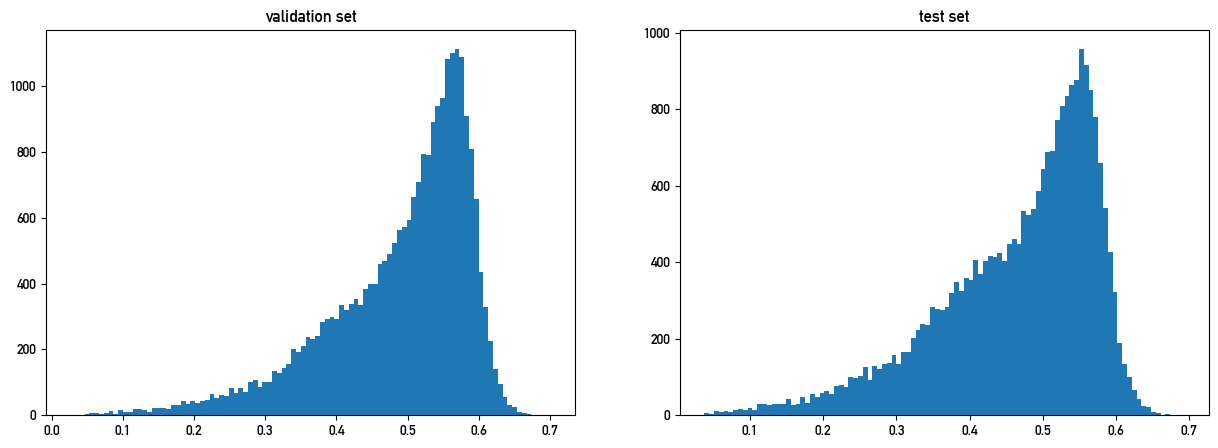

Threshold 1/3 processed.
Threshold 2/3 processed.
Threshold 3/3 processed.
Threshold 1/3 processed.
Threshold 2/3 processed.
Threshold 3/3 processed.
Raster model successfully loaded.
Number of node features: {'focal_building': 9, 'context_building': 9, 'road': 2}, 4 operators
Vector model successfully loaded.
Multimodal model successfully loaded.
Multimodal Model with 21,323,140 parameters consisting of
        raster model (ViT) with 20,520,448 parameters and 
        vector model (HGNN) with 473,984 parameters.


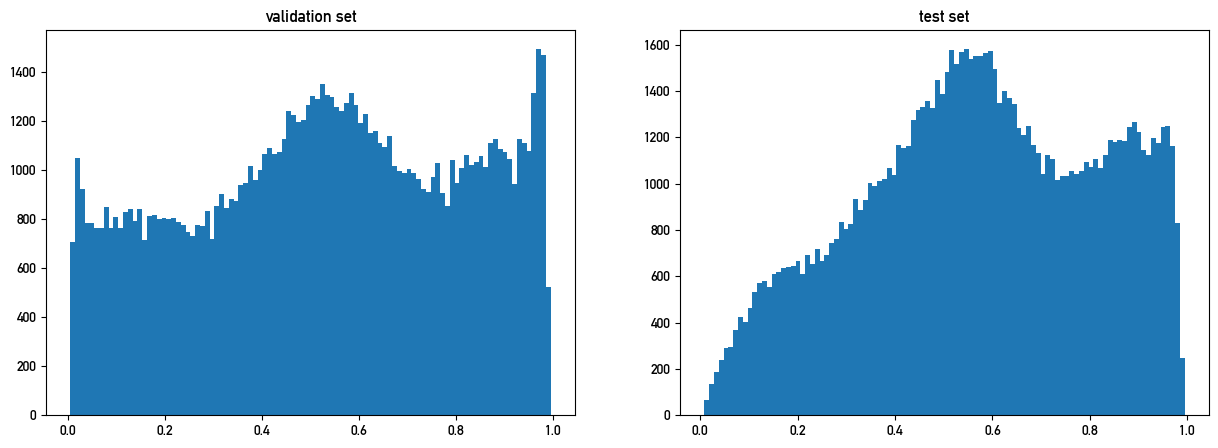

Threshold 1/3 processed.
Threshold 2/3 processed.
Threshold 3/3 processed.
Threshold 1/3 processed.
Threshold 2/3 processed.
Threshold 3/3 processed.


In [9]:
# elimination model
save_multimodal_pr_roc(model_filename="ViT+HGNN_eli_attachRoadsTrue_21067649p_1000s_2ep_bs16_cpu.pth", 
                       interval=interval, 
                       increment=increment)

# multi-operator model
save_multimodal_pr_roc(model_filename="ViT+HGNN_sel_attachRoadsTrue_21323140p_1000s_2ep_bs16_cpu.pth", 
                       interval=interval, 
                       increment=increment)

#### Visualization

##### Validation set

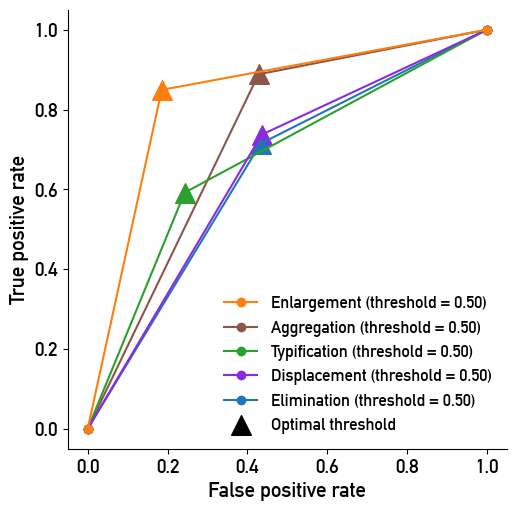

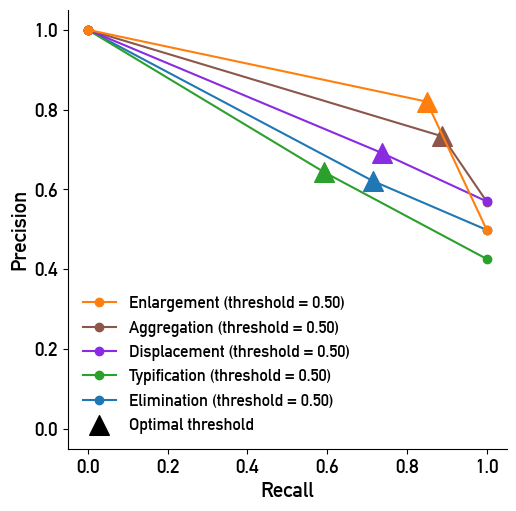

In [10]:
# define paths to PR and ROC CSV files
multimodal_validation_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                             "ViT+HGNN_eli_attachRoadsTrue_21067649p_1000s_2ep_bs16_cpu_validation.csv"),
                                os.path.join(pr_roc_path_selection,
                                             "ViT+HGNN_sel_attachRoadsTrue_21323140p_1000s_2ep_bs16_cpu_validation.csv")]

# output path
figure_path_multimodal_validation_roc = os.path.join(figure_path, "multimodal", "validation_roc.png")
figure_path_multimodal_validation_pr = os.path.join(figure_path, "multimodal", "validation_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "displacement", "elimination"]
pr_order = ["enlargement", "aggregation", "displacement", "typification", "elimination"]

# plot the curves
plot_roc_curve(multimodal_validation_pr_roc, 
               validation=True, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_multimodal_validation_roc)
plot_pr_curve(multimodal_validation_pr_roc, 
              validation=True, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=True, 
              output_path=figure_path_multimodal_validation_pr)

##### Test set

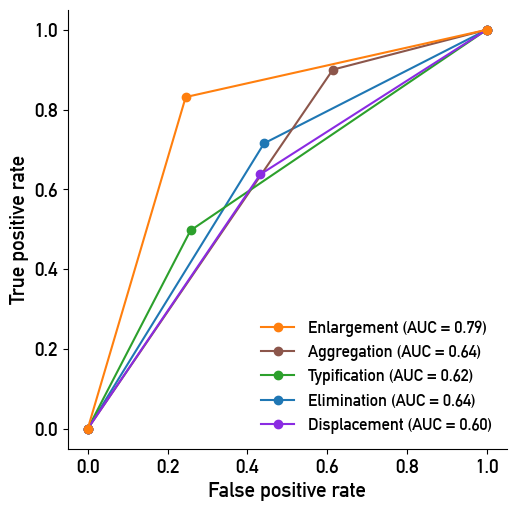

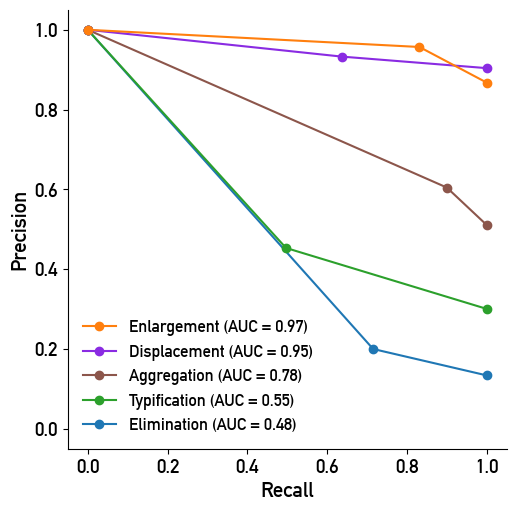

In [11]:
# define paths to PR and ROC CSV files
multimodal_test_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                       "ViT+HGNN_eli_attachRoadsTrue_21067649p_1000s_2ep_bs16_cpu_test.csv"),
                          os.path.join(pr_roc_path_selection,
                                       "ViT+HGNN_sel_attachRoadsTrue_21323140p_1000s_2ep_bs16_cpu_test.csv")]

# output path
figure_path_multimodal_test_roc = os.path.join(figure_path, "multimodal", "test_roc.png")
figure_path_multimodal_test_pr = os.path.join(figure_path, "multimodal", "test_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "elimination", "displacement"]
pr_order = ["enlargement", "displacement", "aggregation", "typification", "elimination"]

# plot the curves
plot_roc_curve(multimodal_test_pr_roc, 
               validation=False, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_multimodal_test_roc)
plot_pr_curve(multimodal_test_pr_roc, 
              validation=False, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=True,
              output_path=figure_path_multimodal_test_pr)

## Accuracy metrics

#### Elimination model

Number of node features: {'focal_building': 2, 'context_building': 2, 'road': 2}, 1 operators
Multimodal model successfully loaded.
Multimodal Model with 4,556,993 parameters consisting of
        raster model (CNN) with 2,469,696 parameters and 
        vector model (HGNN) with 465,024 parameters.


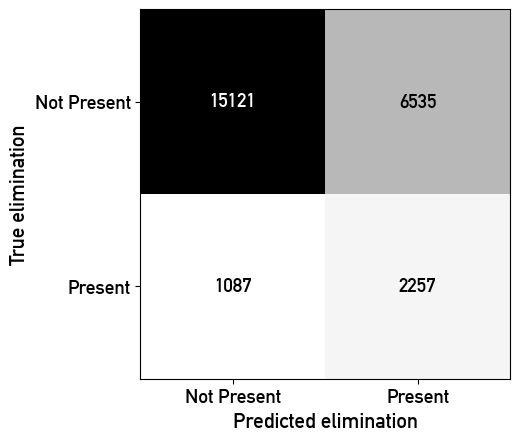

Accuracy: 0.695
Precision: 0.257
Recall: 0.675
F1 Score: 0.372


In [8]:
compute_multimodal_evaluation_metrics("CNN+HGNN_eli_attachRoadsTrue_4556993p_100000s_25ep_bs512_cuda.pth")

#### Multi-operator model

Number of node features: {'focal_building': 9, 'context_building': 9, 'road': 2}, 4 operators
Multimodal model successfully loaded.
Multimodal Model with 9,432,772 parameters consisting of
        raster model (CNN) with 2,469,696 parameters and 
        vector model (HGNN) with 473,984 parameters.


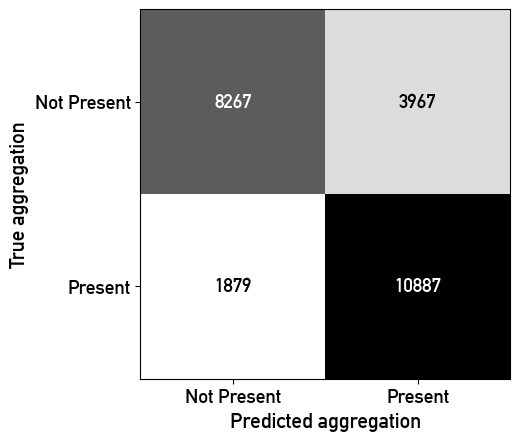

Accuracy: 0.766
Precision: 0.733
Recall: 0.853
F1 Score: 0.788


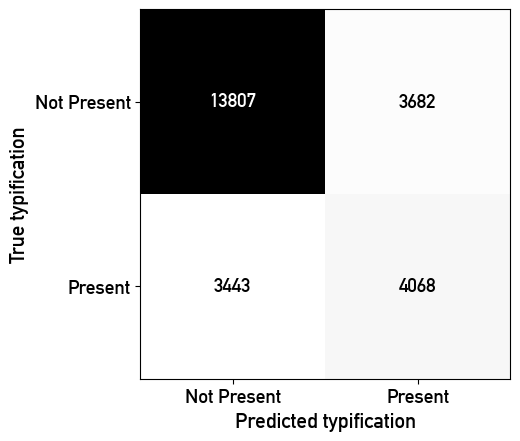

Accuracy: 0.715
Precision: 0.525
Recall: 0.542
F1 Score: 0.533


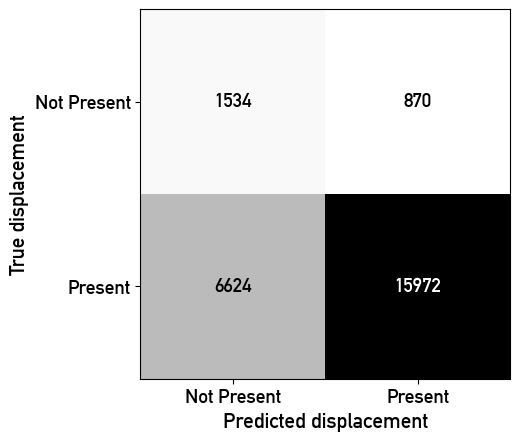

Accuracy: 0.700
Precision: 0.948
Recall: 0.707
F1 Score: 0.810


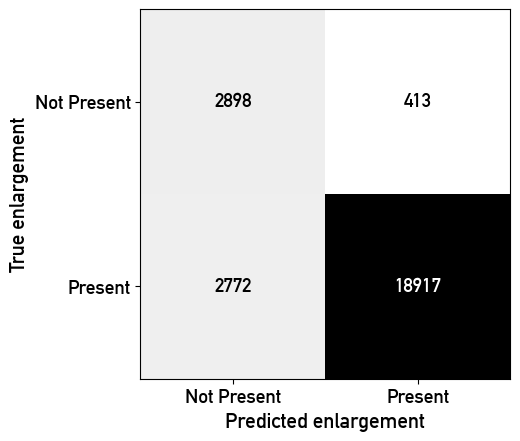

Accuracy: 0.873
Precision: 0.979
Recall: 0.872
F1 Score: 0.922


In [9]:
compute_multimodal_evaluation_metrics("CNN+HGNN_sel_attachRoadsTrue_9432772p_100000s_25ep_bs512_cuda.pth")